WEEK 6 : ASSIGNMENT

BY MUSKAN

Step 1: Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")


Step 2: Load the Wine Dataset

In [2]:
# Load wine dataset
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name='target')

# View shape and preview
print("Shape of X:", X.shape)
print("Target classes:", np.unique(y))
X.head()


Shape of X: (178, 13)
Target classes: [0 1 2]


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Step 3: Exploratory Data Analysis & Visualization

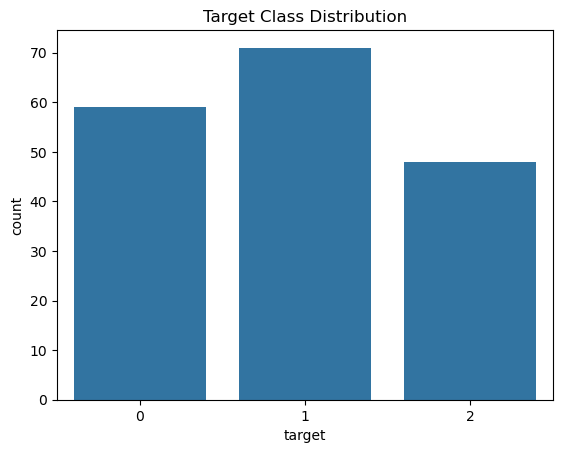

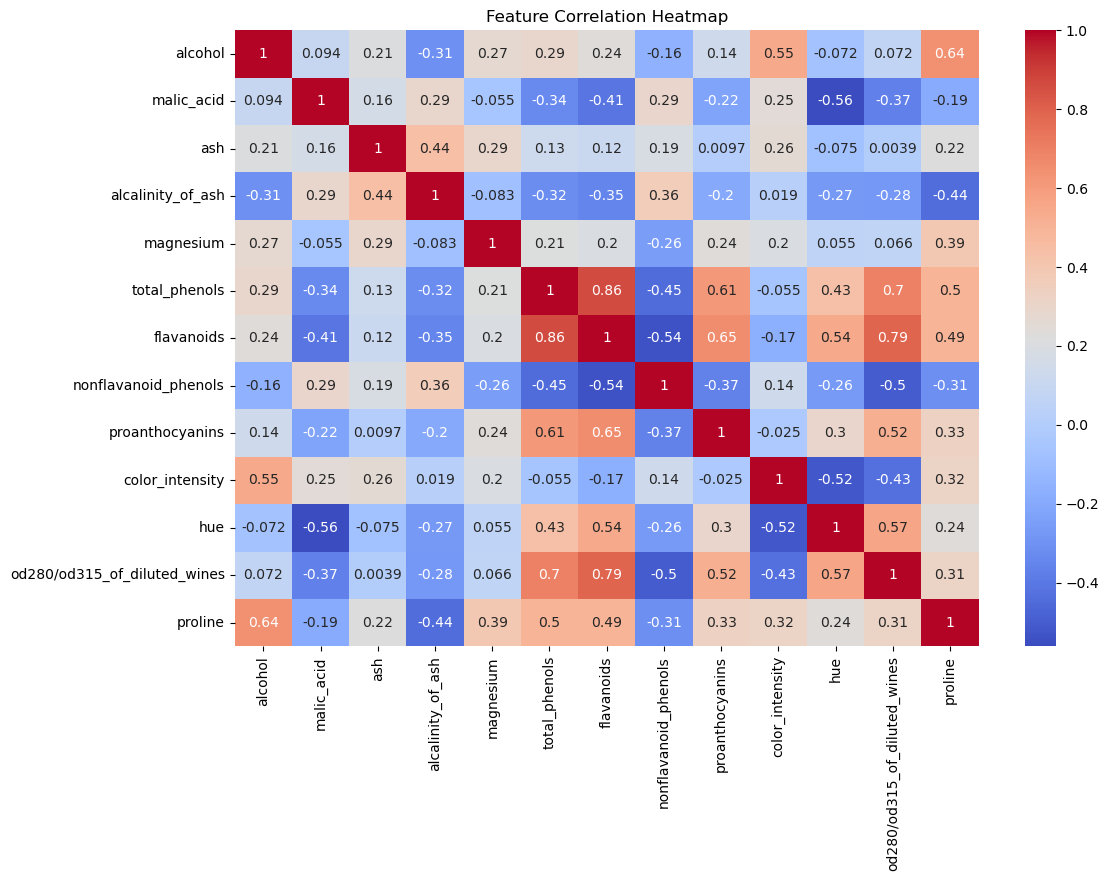

In [3]:
# Class distribution
sns.countplot(x=y)
plt.title("Target Class Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


Step 4: Preprocessing (Train/Test Split + Scaling)

In [4]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Step 5: Feature Selection

In [5]:
# Select top 10 features using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Display selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", list(selected_features))


Selected Features: ['alcohol', 'malic_acid', 'alcalinity_of_ash', 'total_phenols', 'flavanoids', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


Step 6: Train Multiple ML Models

In [6]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

results = []

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted')
    })

results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
print("Initial Model Performance:")
print(results_df)


Initial Model Performance:
                 Model  Accuracy  Precision    Recall  F1 Score
1        Random Forest  1.000000   1.000000  1.000000  1.000000
0  Logistic Regression  0.972222   0.974074  0.972222  0.971970
3                  KNN  0.972222   0.974074  0.972222  0.971970
2                  SVM  0.944444   0.946581  0.944444  0.944269


Step 7: Visualize Model Comparison

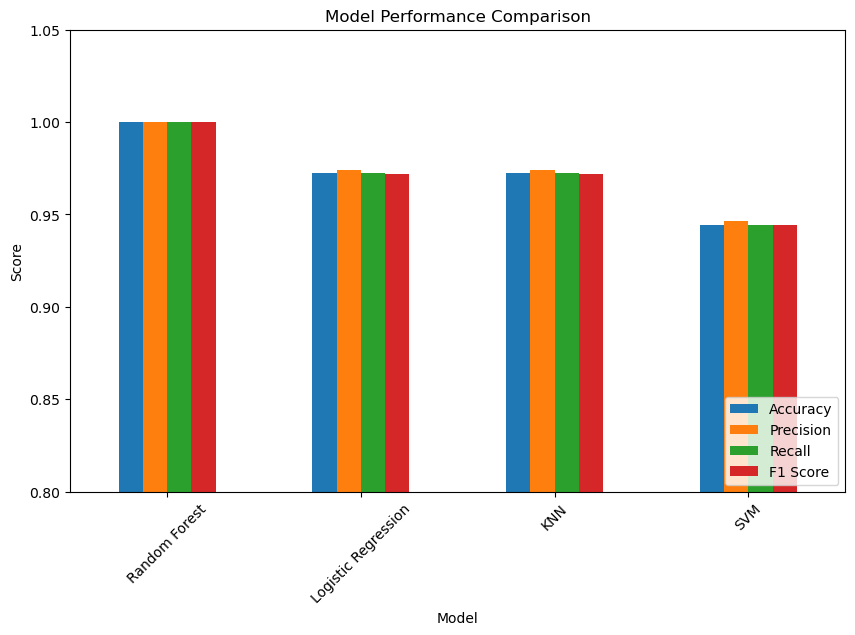

In [7]:
# Bar plot for comparison
results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.8, 1.05)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()


Step 8: Hyperparameter Tuning

GridSearchCV for Random Forest

In [8]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='f1_weighted')
grid_rf.fit(X_train_selected, y_train)

print("Best Random Forest Params:", grid_rf.best_params_)


Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}


RandomizedSearchCV for SVM

In [9]:
param_dist_svm = {
    'C': np.logspace(-3, 2, 6),
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

random_svm = RandomizedSearchCV(SVC(), param_distributions=param_dist_svm, n_iter=10, cv=5, scoring='f1_weighted', random_state=42)
random_svm.fit(X_train_selected, y_train)

print("Best SVM Params:", random_svm.best_params_)


Best SVM Params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10.0}


Step 9: Final Evaluation (Tuned Models)


Classification Report for Tuned Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


Classification Report for Tuned SVM:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.88      1.00      0.93        14
           2       1.00      0.80      0.89        10

    accuracy                           0.94        36
   macro avg       0.96      0.93      0.94        36
weighted avg       0.95      0.94      0.94        36


Tuned Model Performance:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Tuned Random Forest  1.000000   1.000000  1.000000   1.00

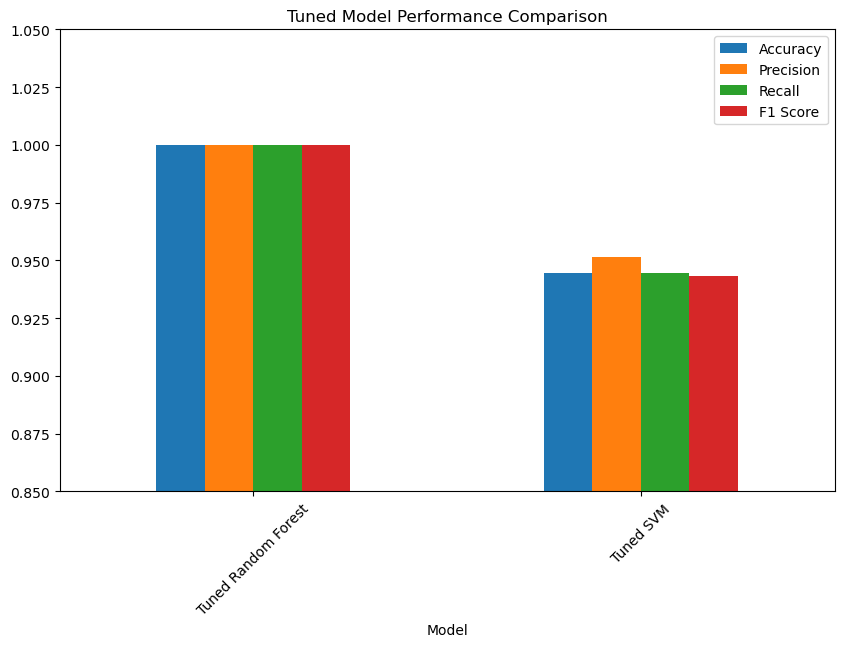

In [10]:
best_models = {
    "Tuned Random Forest": grid_rf.best_estimator_,
    "Tuned SVM": random_svm.best_estimator_
}

tuned_results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test_selected)
    tuned_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted')
    })
    print(f"\nClassification Report for {name}:\n", classification_report(y_test, y_pred))

# Combine and visualize
tuned_df = pd.DataFrame(tuned_results)
print("\nTuned Model Performance:")
print(tuned_df)

tuned_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(10, 6))
plt.title("Tuned Model Performance Comparison")
plt.ylim(0.85, 1.05)
plt.xticks(rotation=45)
plt.show()


Step 10: Conclusion

In [11]:
best_overall = pd.concat([results_df, tuned_df]).sort_values(by='F1 Score', ascending=False)
print("Best Performing Model Overall:")
print(best_overall.head(1))

Best Performing Model Overall:
           Model  Accuracy  Precision  Recall  F1 Score
1  Random Forest       1.0        1.0     1.0       1.0
